# Airline Analysis

## TODO:
- get the distane of the edge based on longitude and latitude ✅
- add all the information to the graph so we have an easy time calculating the measures. ✅
- get list of graph theoretical measures to apply to airline networks:
    - number and strength of hubs 
    - network robustness measures
    - number of/ precense if paths
    - diameter of the graph
    - centrality measures
    - spectrum of graph
    - measure of correlation between country label
    - how much in country/out of country ✅
    - number of triangles in graph
    - set weights if we have multiple fights to same place by same airline ✅
    - get overlaping nodes functions. similarity of graph
- get planes associated with each flight in route, so we can get number of passagers. May do later only for the biggest airlines, at end of analysis ❓

Resources:

Economics:
http://www.oecd.org/daf/competition/airlinecompetition.htm

Graph theoretical:
https://beta.vu.nl/nl/Images/werkstuk-meer_tcm235-280356.pdf

aircraft traffic data by main airport:
https://datamarket.com/data/set/196g/aircraft-traffic-data-by-main-airport#!ds=196g!nto=6:ntp=b:ntq=3:ntr=1.1g.1u.7.z.a.j.v.1b.t.d.s.1n.12.p.8.b.y.e.19.17.1v.9.i.11.1f.1s.1a.1w.x.14.1l.1p.4.k.1r.g.1x.1c.f.15.q.1j.1t.l.1k.1h:nts=nf.rb&display=line





### Loading the dataset:

In [93]:
from  geopy.distance import distance #calculates distance based on coordinates

import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
!bash download_data.sh

Getting airports data
Getting airlines data
Getting routes data
Getting planes data


In [3]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                      na_values='\\N')
airlines = pd.read_csv('airlines.dat', header=None, names=
                       ["AirlineID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"]
                       ,na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                    na_values='\\N')
planes = pd.read_csv('planes.dat', header=None, names=['Name', 'IATA code', 'ICAO code'])

Only keep airports in that are both in routes and airports dataframes:

In [4]:
valid_airports = set(airports.IATA).intersection(set(routes.SourceAirport).union(set(routes.DestinationAirport)))

In [5]:
routes = routes[routes.SourceAirport.isin(valid_airports) &  routes.DestinationAirport.isin(valid_airports)]
airports = airports[airports.IATA.isin(valid_airports)]

Only keep airlines in intersection of that are both in the airline and in the routes dataframe :

In [6]:
valid_airlines = set(airlines.AirlineID).intersection(set(routes.AirlineID))

In [7]:
airlines = airlines[airlines.AirlineID.isin(valid_airlines)]
routes = routes[routes.AirlineID.isin(valid_airlines)]

We check that for each airline we have exactly one edge between a given source and destination none. This means that our graph will be unweighted. 

In [8]:
routes_by_airline = routes[['SourceAirport', 'DestinationAirport', 'Airline']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

### Merging Routes with Airlines:

We are only interessted in currently active airlines:

In [9]:
merged_routes = pd.merge(airlines[airlines.Active == 'Y'], routes, on='AirlineID')

In [10]:
merged_routes.head(1)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,NaN,0,319


Getting whether the flight is international or not:

In [11]:
Airport_to_country = airports.set_index('IATA').Country.to_dict()

In [12]:
merged_routes['International'] = merged_routes.apply(
    lambda x: 1 if Airport_to_country[x.SourceAirport] == Airport_to_country[x.DestinationAirport] else 0, axis=1)

reset frames to create mappings:

In [13]:
#only keep values we are interessted in
airports_filtered = airports[['Name', 'Country', 'Longitude', 'Latitude', 'Timezone', 'IATA', 'City']].copy()

In [14]:
#IATA airport id -> longitude latitude
#airports_filtered.dropna(inplace=True)
airports_filtered.set_index('IATA', inplace=True)

airports_filtered.Longitude.dropna().shape == airports_filtered.Longitude.shape


True

In [15]:

print(airports.Longitude.shape)
print(airports_filtered.Longitude.shape)

(3221,)
(3221,)


In [16]:
location_mapping = airports_filtered.apply(lambda x: [x.Longitude, x.Latitude], axis=1).to_dict()

In [17]:
#Airline name -> airlineID
airline_name_to_number = merged_routes.Name.drop_duplicates().reset_index(drop=True).to_dict()
airline_name_to_number = {v: k for k, v in airline_name_to_number.items()}

In [18]:
merged_routes['AirlineNbr'] = merged_routes.Name.map(airline_name_to_number)

Fill in Nan values:

In [19]:
merged_routes['Codeshare'] = merged_routes.Codeshare.fillna('N')

### Getting the distance between two airports:

Example of functionality:

In [20]:
element = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[0]
element2 = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[1]

In [21]:
distance(element, element2).km

106.2489585209369

In [22]:
distance_mapping = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1).to_dict()


Additing it to merged_routes:

In [23]:
merged_routes['Distance'] = merged_routes.apply(lambda x: 
                distance(distance_mapping[x.SourceAirport], distance_mapping[x.DestinationAirport]).km, axis=1)

In [24]:
relevant_columns = ['Name', 'ICAO', 'Country', 'SourceAirport', 'DestinationAirport', 'Codeshare',
                    'Stops', 'Equipment', 'AirlineNbr', 'International', 'Distance']

In [25]:
merged_routes.head()

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,International,AirlineNbr,Distance
0,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,N,0,319,0,0,767.018752
1,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,ORY,1386.0,N,0,319,0,0,1393.826859
2,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,CDG,1382.0,N,0,319,0,0,1369.896021
3,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LIL,1399.0,N,0,320,0,0,1541.323265
4,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,ALG,210.0,LYS,1335.0,N,0,320 319,0,0,1015.406743


In [26]:
merged_routes[relevant_columns].head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,Aigle Azur,AAF,France,AAE,MRS,N,0,319,0,0,767.018752
1,Aigle Azur,AAF,France,AAE,ORY,N,0,319,0,0,1393.826859
2,Aigle Azur,AAF,France,ALG,CDG,N,0,319,0,0,1369.896021
3,Aigle Azur,AAF,France,ALG,LIL,N,0,320,0,0,1541.323265
4,Aigle Azur,AAF,France,ALG,LYS,N,0,320 319,0,0,1015.406743


In [27]:
merged_routes = merged_routes[relevant_columns]

## Preliminary analysis of the biggest airlines:

In [28]:
merged_routes.Name.value_counts().head(10)

Ryanair                    2482
American Airlines          2340
United Airlines            2172
Delta Air Lines            1977
US Airways                 1947
China Southern Airlines    1420
Air China                  1238
China Eastern Airlines     1215
Southwest Airlines         1140
easyJet                    1130
Name: Name, dtype: int64

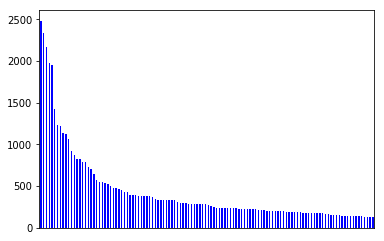

In [29]:
merged_routes.Name.value_counts().head(120).plot(kind='bar', color='b')
_ = plt.xticks([])

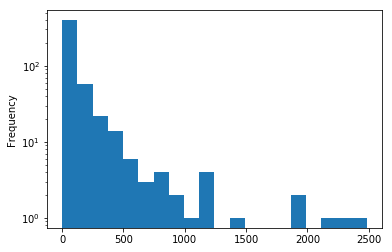

In [30]:
merged_routes.Name.value_counts().plot(kind='hist', log=True, bins=20)

In [31]:
merged_routes.Name.value_counts().describe()

count     517.000000
mean      125.947776
std       276.469028
min         1.000000
25%        14.000000
50%        34.000000
75%       111.000000
max      2482.000000
Name: Name, dtype: float64

In [32]:
reasonably_big_airlines = merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 50].index

In [33]:
merged_routes = merged_routes[merged_routes.Name.isin(reasonably_big_airlines)]

We look at a total of 212 airlines:

In [34]:
merged_routes.Name.unique().shape

(211,)

### Meta-Data analysis

Propotion of international to national flights

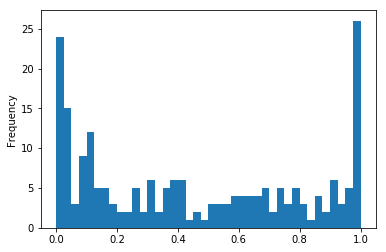

In [35]:
merged_routes.groupby('Name').International.mean().plot(kind='hist', bins=40)

mean distance of flights:

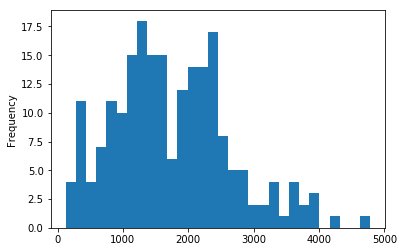

In [36]:
merged_routes.groupby('Name').Distance.mean().plot(kind='hist', bins=30)

Max distance of flights:

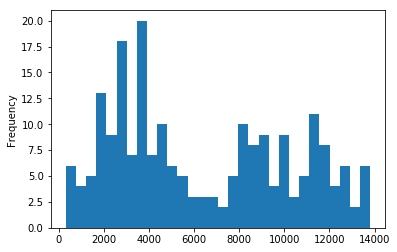

In [37]:
merged_routes.groupby('Name').Distance.max().plot(kind='hist', bins=30)

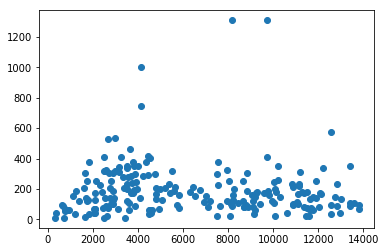

In [38]:
plt.scatter(merged_routes.groupby('Name').Distance.max(),  merged_routes.groupby('Name').Distance.min())

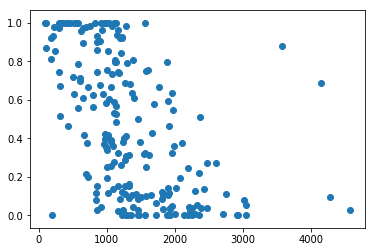

In [39]:
plt.scatter(merged_routes.groupby('Name').Distance.median(),  merged_routes.groupby('Name').International.mean())

shortest distance of flight:

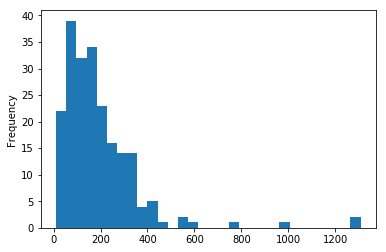

In [40]:
merged_routes.groupby('Name').Distance.min().plot(kind='hist', bins=30)

Proportion of codeshare flights:

In [41]:
merged_routes['Codeshare'] = merged_routes.Codeshare.map(lambda x: 1 if x == 'Y' else 0)

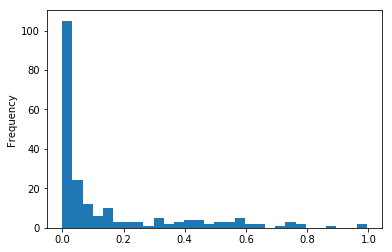

In [42]:
merged_routes.groupby('Name').Codeshare.mean().plot(kind='hist', bins=30)

## Create graph of all airlines:

Create graph with edge having airline associated to

In [43]:
biggest = merged_routes.AirlineNbr.value_counts().head(10).index

In [44]:
edge_attributes = ['Country', 'Name', 'AirlineNbr', 'Distance', 'International']

In [45]:
Airline_Graph = nx.from_pandas_edgelist(merged_routes[merged_routes.AirlineNbr.isin(biggest)], 
                                        source='SourceAirport', 
                                        target='DestinationAirport', 
                                        edge_attr=['Country', 'Name', 'AirlineNbr', 'Distance', 'International'])

In [46]:
color_edges = list(nx.get_edge_attributes(Airline_Graph, 'AirlineNbr').values())

In [47]:
nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


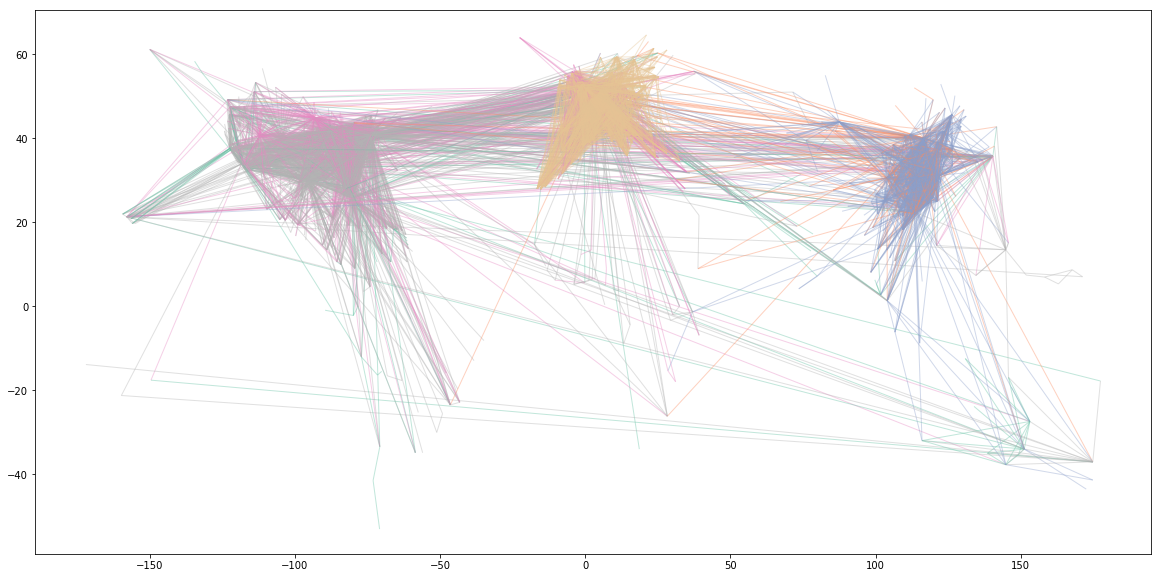

In [48]:
plt.figure(figsize=(20, 10))
nx.draw_networkx(Airline_Graph, 
                 pos=nx.get_node_attributes(Airline_Graph, 'Location'), 
                 edge_color=color_edges, edge_cmap=plt.cm.Set2, node_size=0, labels=dict(), alpha=0.4)

Example analysis of one graph:

In [49]:
def create_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])
    nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')
    return Airline_Graph

In [50]:
Ryanair = create_airline_network('Ryanair')

In [51]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Ryanair).todense())

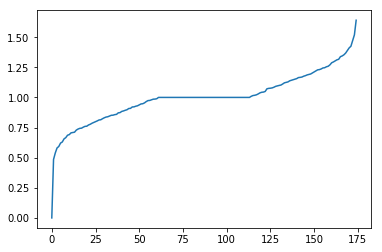

In [52]:
plt.plot(e)

In [53]:
Lufthansa = create_airline_network('Lufthansa')

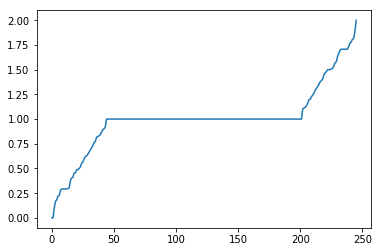

In [54]:
e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Lufthansa).todense())
plt.plot(e)

In [55]:
nx.node_connectivity(Ryanair)

1

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

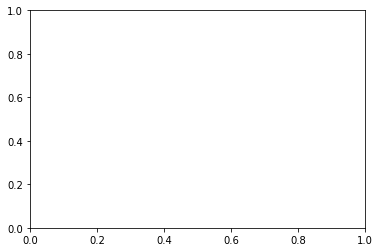

In [56]:
plt.boxplot(nx.degree_centrality(Ryanair).values())

In [ ]:
nx.average_clustering(Ryanair)

In [ ]:
nx.k_nearest_neighbors(Ryanair)

In [ ]:
nx.triangles(Ryanair)

In [ ]:
nx.diameter(Ryanair)

In [ ]:
nx.estrada_index(Ryanair)

In [ ]:
nx.eccentricity(Ryanair)

In [ ]:
merged_routes.Name.value_counts().plot(kind='box')

In [ ]:
merged_routes.Name.value_counts().describe()

In [ ]:
merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 100]

In [ ]:
merged_routes.Country.value_counts().head(20)

In [ ]:
merged_routes.Codeshare.value_counts()

In [ ]:
Low_cost = ['Southwest Airlines', 'Virgin America', 'AirAsia', 'Ryanair','easyJet', 'WestJet', 'Pegasus Airlines', 'Spirit Airlines', 'Mango']

In [ ]:
merged_routes[merged_routes.Name.isin(Low_cost)].Name.value_counts()

In [ ]:
merged_routes.head()

In [57]:
def draw_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])

    plt.figure(figsize=(10, 10))
    centrality = nx.betweenness_centrality(Airline_Graph)
    size = np.array(list(centrality.values()))*1000
    nx.draw_spring(Airline_Graph, node_size=size, width=0.1)
    plt.title(airline)
    plt.show()
    e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Airline_Graph).todense())
    plt.plot(e)
    plt.show()
    plt.plot(nx.laplacian_spectrum(Airline_Graph))
    plt.show()
    plt.boxplot(nx.degree_centrality(Airline_Graph).values())
    plt.show()
    

In [58]:
for cheap in Low_cost:
    draw_airline_network(cheap)

NameError: name 'Low_cost' is not defined

In [59]:
Best_Airlines = ['Singapore Airlines', 'Emirates', 'Lufthansa', 'Qatar Airways', 'Cathay Pacific']

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


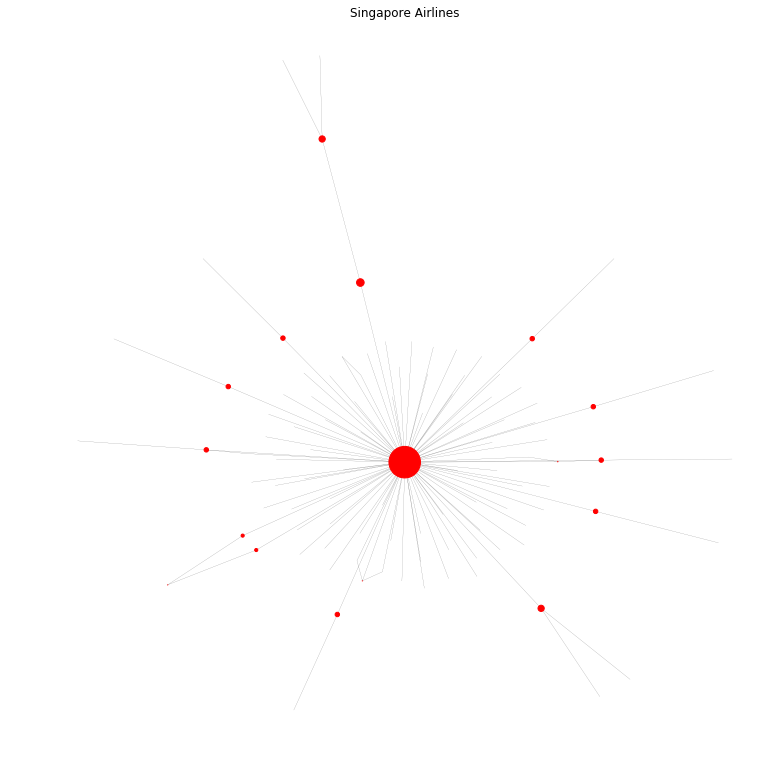

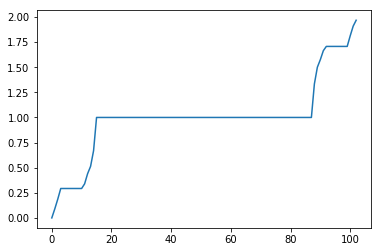

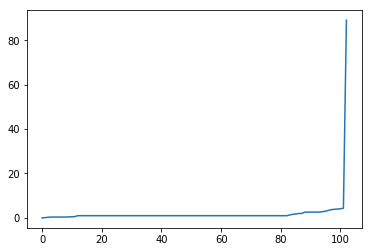

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

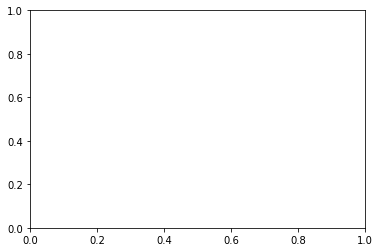

In [60]:
for best in Best_Airlines:
    draw_airline_network(best)

In [ ]:
Large_Airlines = ['Delta Air Lines', 'Air France', 'China Southern Airlines', 'Turkish Airlines', 'American Airlines']

In [ ]:
for best in Large_Airlines:
    draw_airline_network(best)

In [ ]:
merged_routes.Name.unique()

In [ ]:
Chinese = ['China Southern Airlines', 'China Eastern Airlines', 'Air China']

In [ ]:
for best in Chinese:
    draw_airline_network(best)

## Adding in external information: for relected airlines - case study

In [61]:
Delays_data = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - Delays data (raw).csv')

FileNotFoundError: File b'\xf0\x9f\x8f\xac AIRLINE LIST  \xe2\x9c\x88\xef\xb8\x8f  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - Delays data (raw).csv' does not exist

In [62]:
Airline_list = pd.read_csv('🏬 AIRLINE LIST  ✈️  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - 🏬 Airlines.csv')

FileNotFoundError: File b'\xf0\x9f\x8f\xac AIRLINE LIST  \xe2\x9c\x88\xef\xb8\x8f  v0.3    by @levelsio _ CLICK PLANES IN THE PANE BELOW - \xf0\x9f\x8f\xac Airlines.csv' does not exist

In [63]:
set(Airline_list.name.map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

NameError: name 'Airline_list' is not defined

In [64]:
merged_routes.Name.head()

0    Aigle Azur
1    Aigle Azur
2    Aigle Azur
3    Aigle Azur
4    Aigle Azur
Name: Name, dtype: object

In [65]:
set(Delays_data['On-time'].map(lambda x: x.lower())).intersection(set(merged_routes.Name.map(lambda x: x.lower())))

NameError: name 'Delays_data' is not defined

# Networks Analysis

In [127]:
def airlines_network_analysis(airline):
    
    Airline_Graph = create_airline_network(airline)
    
    #Highlights hubs   
    print("10% biggest airports of ", airline)
    print()
    deg = np.array(list(Airline_Graph.degree))
    deg_value = deg[:,1]
    deg_value = deg_value.astype(np.float)
    plt.hist(deg_value, bins=50, )
    perc = np.percentile(deg_value, q=90)
    biggest_hubs = np.array(np.where(deg_value > perc))

    for i in np.nditer(biggest_hubs):
        print(airports[airports.IATA == deg[i,0]].Name.to_string(index=False), "has degree : ", deg[i,1])
    
    
    #Diameter,robustness
    print("Anlysis")
    print("Number of edges : ", Airline_Graph.number_of_edges())
    print("Number of nodes", Airline_Graph.number_of_nodes(), "nodes")
    print("Diameter : ", nx.diameter(Airline_Graph))
    print("Node connectivity", nx.node_connectivity(Airline_Graph))
    
    eb = nx.edge_betweenness_centrality(Airline_Graph)
    key, value = max(eb.items(), key = lambda p: p[1])
    print("Max edge betwenness: ",value , "from ", airports[airports.IATA == key[0]].Name.to_string(index=False), "to", airports[airports.IATA == key[1]].Name.to_string(index=False))
    key, value = min(eb.items(), key = lambda p: p[1])
    print("Min edge betwenness: ",value, "from", airports[airports.IATA == key[0]].Name.to_string(index=False), "to", airports[airports.IATA == key[1]].Name.to_string(index=False))
                                                            
    nb = nx.betweenness_centrality(Airline_Graph)
    key, value = max(nb.items(), key= lambda p:p[1])
    print("Max node betwenness: ", value, "airport",airports[airports.IATA == key].Name.to_string(index=False))
    key, value = min(nb.items(), key= lambda p:p[1])
    print("Min node betwenness: ", value, "airport",airports[airports.IATA == key].Name.to_string(index=False))
    print("Algbraic connectivity: ", nx.algebraic_connectivity(Airline_Graph))
    
    #Plot network
    draw_airline_network(airline)
    

10% biggest airports of  Ryanair

Málaga Airport has degree :  50
Palma De Mallorca Airport has degree :  49
London Stansted Airport has degree :  123
Barcelona International Airport has degree :  39
Il Caravaggio International Airport has degree :  63
Paris Beauvais Tillé Airport has degree :  46
Brussels South Charleroi Airport has degree :  75
Dublin Airport has degree :  76
East Midlands Airport has degree :  37
Frankfurt-Hahn Airport has degree :  43
Manchester Airport has degree :  36
Weeze Airport has degree :  38
Ciampino–G. B. Pastine International Airport has degree :  45
Girona Airport has degree :  44
Pisa International Airport has degree :  43
Alicante International Airport has degree :  42
Francisco de Sá Carneiro Airport has degree :  36
Anlysis
Number of edges :  1241
Number of nodes 175 nodes
Diameter :  4
Node connectivity 1
Max edge betwenness:  0.01578706251317574 from  London Stansted Airport to Marseille Provence Airport
Min edge betwenness:  0.0002385917981071223

/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


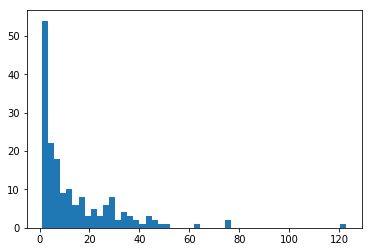

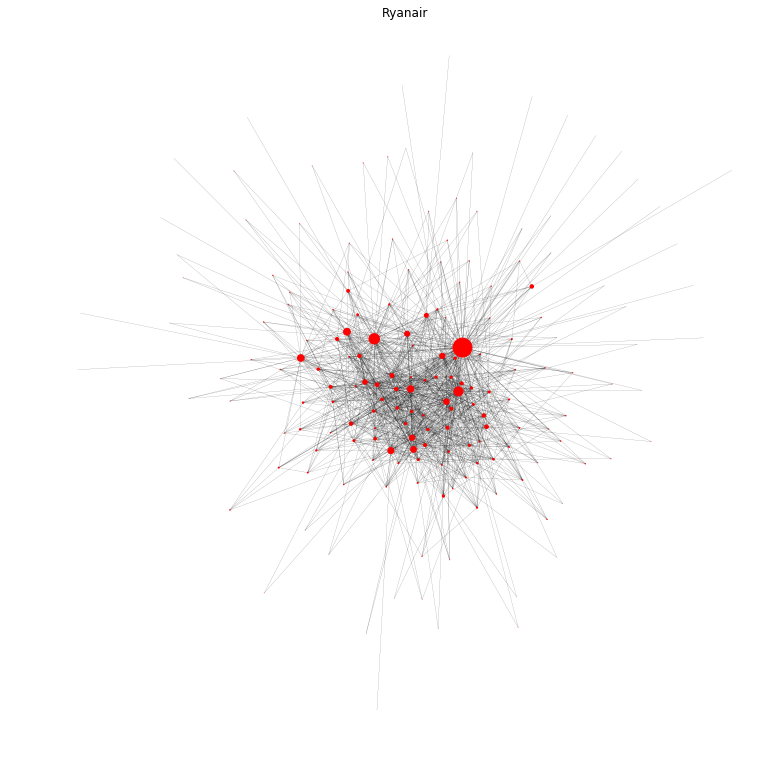

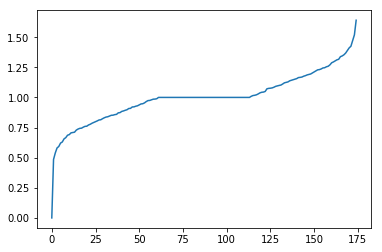

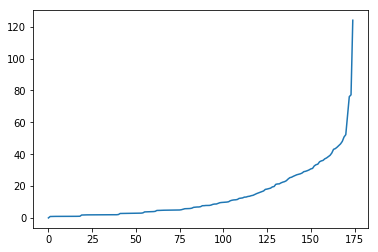

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

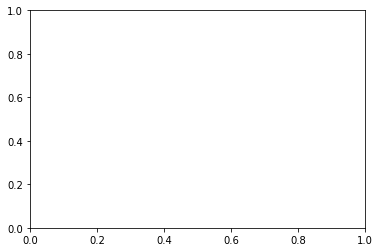

In [128]:
airlines_network_analysis('Ryanair')

10% biggest airports of  Turkish Airlines

Atatürk International Airport has degree :  221
Esenboğa International Airport has degree :  32
Sabiha Gökçen International Airport has degree :  36
Adnan Menderes International Airport has degree :  4
Addis Ababa Bole International Airport has degree :  5
Douala International Airport has degree :  5
Suvarnabhumi Airport has degree :  9
Antalya International Airport has degree :  7
Incheon International Airport has degree :  6
Anlysis
Number of edges :  336
Number of nodes 254 nodes
Diameter :  6
Node connectivity 1
Max edge betwenness:  0.049018082225887785 from  Atatürk International Airport to Suvarnabhumi Airport
Min edge betwenness:  3.1122591889452555e-05 from Aalborg Airport to Billund Airport
Max node betwenness:  0.972721521634565 airport Atatürk International Airport
Min node betwenness:  0.0 airport Aalborg Airport
Algbraic connectivity:  0.19755442211773067


/home/runner/miniconda3/envs/ntp/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


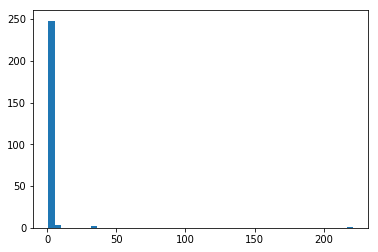

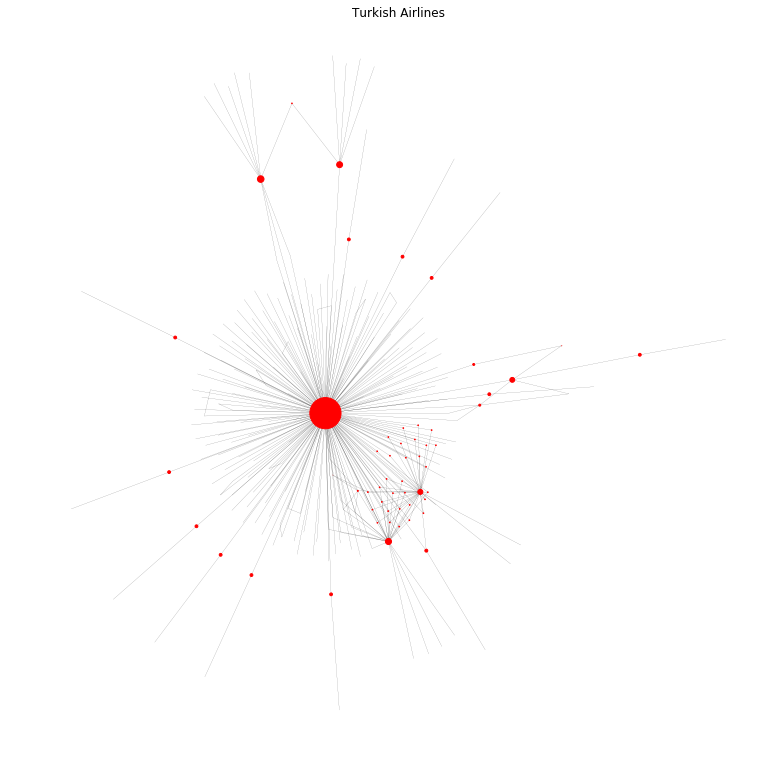

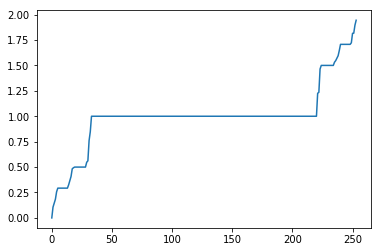

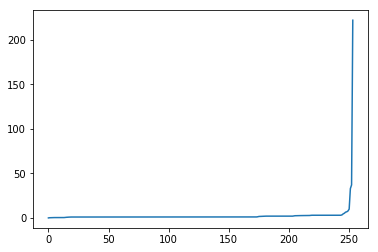

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

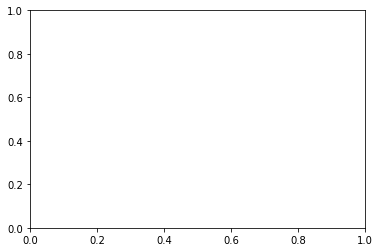

In [129]:
airlines_network_analysis('Turkish Airlines')